$k$-means clustering is an unsupervised learning algorithm, meant to group unlabaled datasets into $k$ different clusters. We'll implement such an algorithm, and then compare our implementation to that of the scikit-learn library.

As always, we begin with a dataset, which we shall construct. For simplicity, we shall use scikit-learn's `make_blob` function. It is possible, however, to simply create $k$ clusters using NumPy's random number generator. See, for example, our KNN project.

In [14]:
from sklearn.datasets import make_blobs

# Define number of clusters
k = 4

points, _ = make_blobs(n_samples=1000, centers=k, cluster_std=5, random_state=42)

Let's do a quick plot.

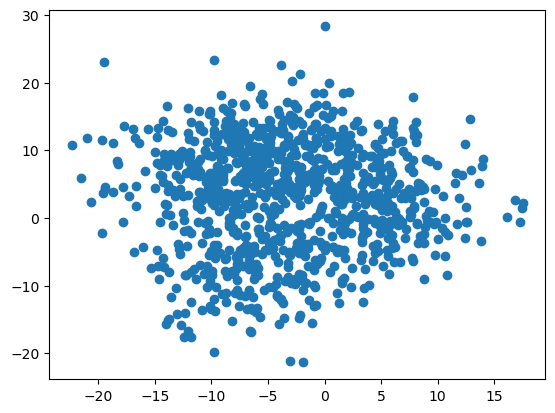

In [15]:
import matplotlib.pyplot as plt

plt.scatter(points[:, 0], points[:, 1])
plt.show()

Before we proceed with the algorithm, we ought to describe the steps.

1. Pick $k$ data points at random and initialize them as the centroids of the clusters.
2. Find the Euclidean distance from each of these clusters to every other point in the dataset.
3. Associate each datapoint with its nearest centroid, thus forming a cluster around a centroid.
4. Update the centroids to be the geometric mean of all datapoints within its cluster.
5. Repeat steps 2-5 until a desired number of iterations is hit, or until the centroids no longer change.

Euclidean distance is given by the formula
$$d(p, q) = \sqrt{\sum_{i = 1}^n (q_i - p_i)^2}.$$
The centroids $c_i$ can be updated to the geomtric mean of their clusters by
$$c_i = \frac{1}{\lvert S_i \rvert} \sum_{x_i \in S_i} x_i,$$
where $S_i$ is the set of all datapoints within the $i$-th cluster, and $\lvert S_i \rvert$ its cardinality.

In [16]:
import numpy as np

np.random.seed(42)

class kmeans:
    def __init__(self, k=3, iterations=100):
        self.k = k
        self.iterations = iterations

    # Euclidean distance
    def eucl_distance(self, p, q):
        return np.sqrt(np.sum((q - p) ** 2))

    def fit(self, points):
        iteration_count = 0

        # Begin by choosing k of the points at random to be centroids
        self.centroids = []
        centroids_prev = [np.array([]) for i in range(self.k)]
        random_indices = np.random.choice(points.shape[0], self.k, replace=False)

        for i in range(self.k):
            self.centroids.append(points[random_indices[i]])

        while iteration_count < self.iterations:
            # Create dictionaries for each cluster, containing its associated points
            self.cluster = {i: [] for i in range(self.k)}

            # Finding distance for each point and appending it to a list
            for point in points:
                distances = []
                for i, j in enumerate(self.centroids):
                    distances.append(self.eucl_distance(point, self.centroids[i]))

                # Determining cluster
                index = np.argmin(distances)            # Index of minimum distance
                self.cluster[index].append(point)

            centroids_prev = self.centroids.copy()

            # Update centroid to geometric mean
            for i in range(self.k):
                self.centroids[i] = np.mean(self.cluster[i], axis=0)
            
            # Check for convergence
            convergence_count = 0
            for i in range(self.k):
                if np.array_equal(self.centroids[i], centroids_prev[i]):
                    convergence_count += 1
                    if convergence_count == self.k:
                        return self.centroids, iteration_count
                else:
                    convergence_count = 0

            iteration_count += 1

        return self.centroids, iteration_count

Now we test it.

In [17]:
kmeans = kmeans(k=k, iterations=100)
centroids, iteration_count = kmeans.fit(points)

print(f'Finished in {iteration_count} iterations.')
print(centroids)

Finished in 13 iterations.
[array([-0.59575617, 10.41990269]), array([-9.94023874,  7.228672  ]), array([-6.48630975, -7.51733908]), array([5.51390778, 0.53249169])]


### Visualization

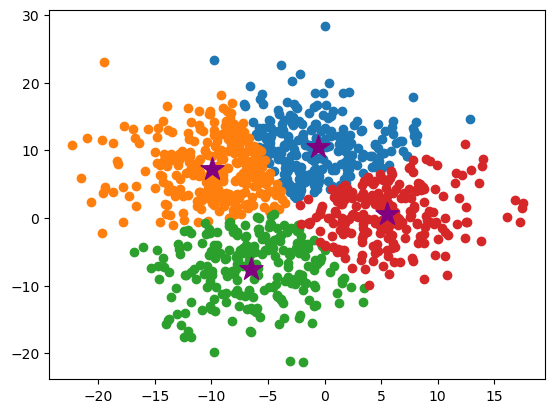

In [18]:
for i in range(k):
    plt.scatter(np.array(kmeans.cluster[i])[:, 0], np.array(kmeans.cluster[i])[:, 1])

# Plot centroids
centroids = np.array(centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='purple')

plt.show()

## Comparison with scikit-learn's $k$-means implementation

In [21]:
from sklearn.cluster import KMeans

kmeans_sk = KMeans(n_clusters=k)
kmeans_sk.fit(points)
labels_sk = kmeans_sk.predict(points)
centroids_sk = kmeans_sk.cluster_centers_

centroids_sk

c:\Program Files\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Program Files\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


array([[-0.6674316 , 10.51069944],
       [-6.42314734, -7.55755323],
       [-9.96330476,  7.15812726],
       [ 5.46498993,  0.63309143]])

The centroids (ignoring order) are extremely close to the ones we got. Now let's plot it alongside ours.

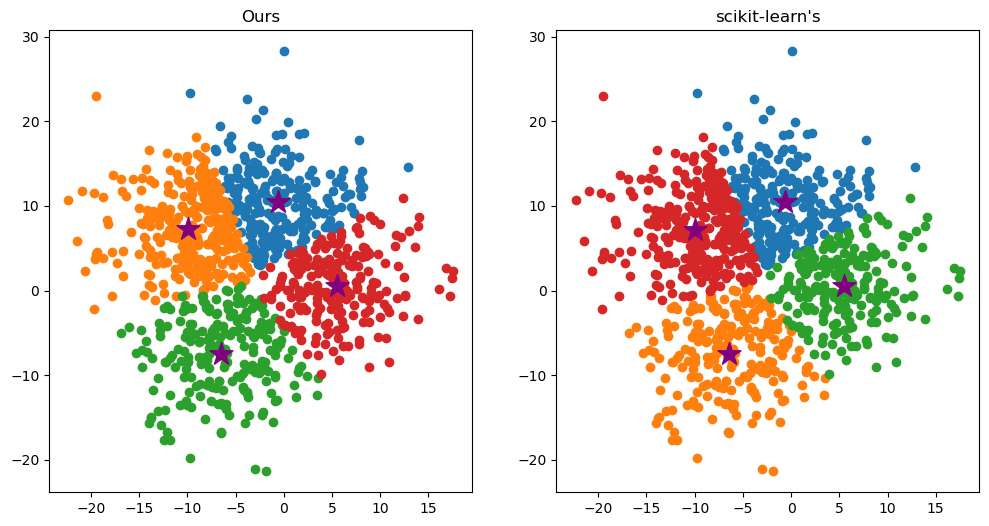

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for our implementation
axs[0].set_title('Ours')
for i in range(k):
    axs[0].scatter(np.array(kmeans.cluster[i])[:, 0], np.array(kmeans.cluster[i])[:, 1])
axs[0].scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='purple')

# Plot for scikit-learn implementation
axs[1].set_title("scikit-learn's")
for i in range(k):
    axs[1].scatter(points[labels_sk == i, 0], points[labels_sk == i, 1])
axs[1].scatter(centroids_sk[:, 0], centroids_sk[:, 1], marker='*', s=300, c='purple')

plt.show()

As we can see, again disregarding a switching of labels for the clusters, we arrive at almost exactly the same result.

In [10]:
kmeans_sk.n_iter_

9

We do wish to make a final remark of scikit-learn's implementation arriving at the result with fewer iterations compared to ours (9 vs 13). This is likely due to scikit-learn utilizing the [kmeans++](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)'s ([Wikipedia](https://en.wikipedia.org/wiki/K-means%2B%2B)) more efficient method of choosing starting centroids.